# TP 2
# Build your own simulations

### Objectives

Use ATOM as is without writing code. Manipulate / Check the
traces

Atom documentation: http://atom.univ-lille1.fr/AtomDoc.html  
Documentation R: https://www.r-project.org/manuals.html

**Previous knowledge** : Python basics


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import random
FILES = "files/"

from atom import *
from data_processing import *
import statsmodels.tsa.stattools as stats
plt.rcParams['figure.figsize'] = (15,10)

## 1 Rewrite a Generate equivalent

_not equivalent to Java_



## 2 More advanced ZITs

By default, the ZITs decide randomly whether to deposit an Ask or Bid order randomly. It is nevertheless possible to pass
in parameter the two probabilities to send a Bid or an ask :

`t = ZITTrader(m, q_min=1,q_max=10,p_min=100, p_max=999, pb_ask=0.2, pb_bid=0.3)`

creates an agent who only speaks with 50% of the time, and who, when he speaks, decides to send more BIDs (30%) than
of ASK (20%), on a quantity between 1 and 10 and a price between 100 and 999.

**1. Create an Imbalance market that invokes only 2 agents, one with 20% and 30% (resp Ask and Bid) and
the other with 40% and 50% (resp Ask and Bid), over a continuous period of 1000 rounds of speech.**

In [2]:
file = open('trace.dat', 'w')
m = Market(['Apple'],out=file)
t1 = ZITTrader(m, p_min=100, p_max=999, pb_ask=0.2, pb_bid=0.3)
t2 = ZITTrader(m, p_min=100, p_max=999, pb_ask=0.4, pb_bid=0.5)
m.add_trader(t1)
m.add_trader(t2)
for i in range(1000):
    m.run_once()
m.print_state()

traders_id = []
for trader in m.traders:
    traders_id.append(trader.trader_id)
    
file.close()

**2. How to check the initial statistics in the result file? **

In [3]:
zit1 = "ZIT "+str(traders_id[0])
file = open('trace.dat','r')
line = file.readline()
tot=0
bid=0
ask=0
while(line!=""):
    if ("LimitOrder;Apple;"+zit1 in line and line[0]!='#'):
        if (line.split(";")[3])=="BID":
            bid+=1
        else:
            ask+=1
        tot+=1
    line = file.readline()
print("Agent {} sent {} orders on {}% of the ticks".format(zit1,tot,tot/10))
print("composed of {} asks (on {}% of ticks) and {} ({}% of ticks) bids".format(ask,ask/10,bid,bid/10))

Agent ZIT 1 a envoyé 493 ordres soit sur 49.3% des ticks
composés de 227 asks (sur 22.7% des ticks) et 266 (26.6% des ticks) bids


## 3 Speed tests



**1. Create a market simulation with a single asset and 1000 ZIT agents, which performs 1000 rounds of speech (thus 1
million orders executed by the market).**  
_100 million = bcp too long in python_.

In [4]:
import time
t = time.time()
m = Market(['Apple'],trace="")
#m.generate(1000, 1000)
print(int((time.time()-t)),"s")

0 s


## 4 Difficulty not to ruin oneself

The ModerateAgent is a ZIT that waits for the full execution of the sent order before sending a new one.
The IntelligentAgent is a ModerateAgent who, in addition, always checks that he has enough cash not to go into
negative values.  


**1. Launch a market that checks the ModerateAgent is working properly: it will contain 1 Moderate
and 10 ZITs that run for 1000 rounds of speech.  
At the end of the simulation , we will display its cash, its investments and the valuation of its final portfolio. Check in the execution trace that the Moderate agent is working properly.

In [5]:
class ModerateTrader(Trader):
    def __init__(self, market, initial_assets=None, cash=0):
        Trader.__init__(self, market, initial_assets, cash)
    def __str__(self):
        return "MOD " + super().__str__()
    def decide_order(self, market, asset):
        # We're counting the number of orders placed in the orderbooks by this agent 
        nb_placed_orders = sum(len([o for o in market.orderbooks[asset2].asks.tree+market.orderbooks[asset2].bids.tree if o.source == self]) for asset2 in market.orderbooks.keys())
        if nb_placed_orders == 0:
            direction = random.choice(['ASK', 'BID'])
            if direction == 'ASK':
                return LimitOrder(asset, self, 'ASK', random.randint(1000, 9999), random.randint(1, 9))
            elif direction == 'BID':
                price = random.randint(1000, 9999)
                # We don't place a BID for a volume of assets with a total value > to the cash we have.
                return LimitOrder(asset, self, 'BID', price, random.randint(1, 9))
        return None # In all other cases, we don't place an order 

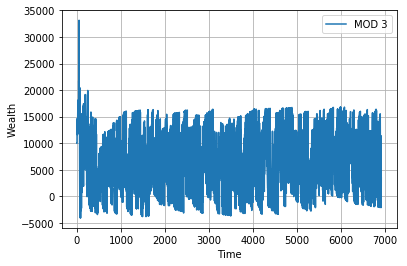

Avec 10000  de cash au départ
Wealth : 3494 (peut être négatif)
Profit : -6506


In [6]:
file = open('trace_moderate.dat', 'w')
m = Market(['Apple'],out=file)
cash = 10000
moderate = ModerateTrader(m,cash=cash) # Must have cash at the start
m.add_trader(moderate)

for i in range(10):
    t = ZITTrader(m,cash=cash)
    m.add_trader(t)

for i in range(1000):
    m.run_once()
m.print_state()   
file.close()

Wealths = extract_wealths('trace_moderate.dat')
for agent in Wealths.keys():
    if "MOD" in agent:
        magent = agent
T, W = Wealths[magent]
plt.plot(W, '-', label=magent)
plt.legend(loc='best')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Wealth')
plt.show()
print("With",cash," of cash at the start")
print("Wealth :",W[-1],"(can be negative)")
print("Profit :",W[-1]-cash)

**2. Launch a market that verifies the proper functioning of the IntelligentAgent: it will contain
1 Intelligent and 10 ZIT that run for 1000 rounds of speech. At the end of the simulation, you will display its cash, its investments and the
valuation of its final portfolio. Check in the execution trace the correct operation of the Intelligent Agent**.

In [7]:
class IntelligentTrader(Trader):
    def __init__(self, market, initial_assets=None, cash=0):
        Trader.__init__(self, market, initial_assets, cash)
    def __str__(self):
        return "INT " + super().__str__()
    def decide_order(self, market, asset):
        # We're counting the number of orders placed in the orderbooks by this agent 
        nb_placed_orders = sum(len([o for o in market.orderbooks[asset2].asks.tree+market.orderbooks[asset2].bids.tree if o.source == self]) for asset2 in market.orderbooks.keys())
        if nb_placed_orders == 0:
            direction = random.choice(['ASK', 'BID'])
            if direction == 'ASK' and self.assets[asset] > 0: # If we have quantity > 0 of shares for this asset... 
                # You don't sell an amount of stock > to the one you have.
                return LimitOrder(asset, self, 'ASK', random.randint(1000, 9999), random.randint(1, min(self.assets[asset], 9)))
            elif direction == 'BID' and self.cash >= 1000: # To buy, you need money... 
                price = random.randint(1000, min(self.cash, 9999))
                # We don't place a BID for a volume of assets with a total value > to the cash we have.
                return LimitOrder(asset, self, 'BID', price, random.randint(1, min(self.cash//price, 9)))
        return None # In all other cases, we don't place an order

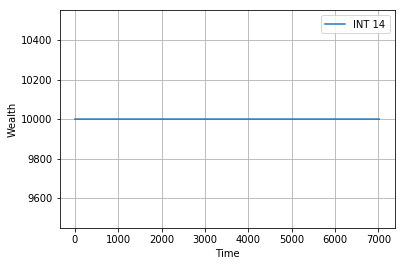

Avec 10000  de cash au départ
Wealth : 10000 (ne peut être négatif)
Profit : 0


In [8]:
file = open('trace_intelligent.dat', 'w')
m = Market(['Apple'],out=file)
cash = 10000
intelligent = IntelligentTrader(m,cash=cash) # Must have cash at the start
m.add_trader(intelligent)

for i in range(10):
    t = ZITTrader(m,cash=cash)
    m.add_trader(t)

for i in range(1000):
    m.run_once()
m.print_state()   
file.close()

Wealths = extract_wealths('trace_intelligent.dat')
for agent in Wealths.keys():
    if "INT" in agent:
        iagent = agent
T, W = Wealths[iagent]
plt.plot(W, '-', label=iagent)
plt.legend(loc='best')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Wealth')
plt.show()
print("With",cash," of cash at the start")
print("Wealth :",W[-1],"(can be negative)")
print("Profit :",W[-1]-cash)

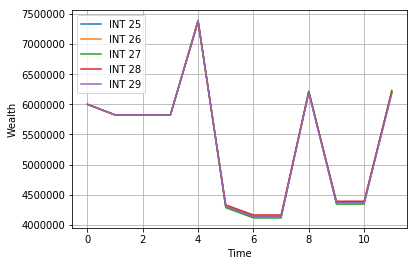

Tout est bloqué très rapidement. Chacun attend que son ordre soit exécuté -> deadlock


In [9]:
file = open('trace_all_intelligent.dat', 'w')
m = Market(['Apple'],out=file)
cash = 1000000
for i in range(5):
    t = IntelligentTrader(m,initial_assets=[1000],cash=cash)
    m.add_trader(t)

for i in range(1000):
    m.run_once()
m.print_state()   
file.close()

Wealths = extract_wealths('trace_all_intelligent.dat')
for agent in Wealths.keys():
    T, W = Wealths[agent]
    plt.plot(W, '-', label=agent)
plt.legend(loc='best')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Wealth')
plt.show()

print("Everything got stuck very quickly. Everyone waits for his order to be executed -> deadlock")